In [ ]:
import numpy as np
import ultraplot as uplt
import scipy.optimize

chi2 before and after variance adjustment (dof=3): 9.846900708075317 2.8117037416276056


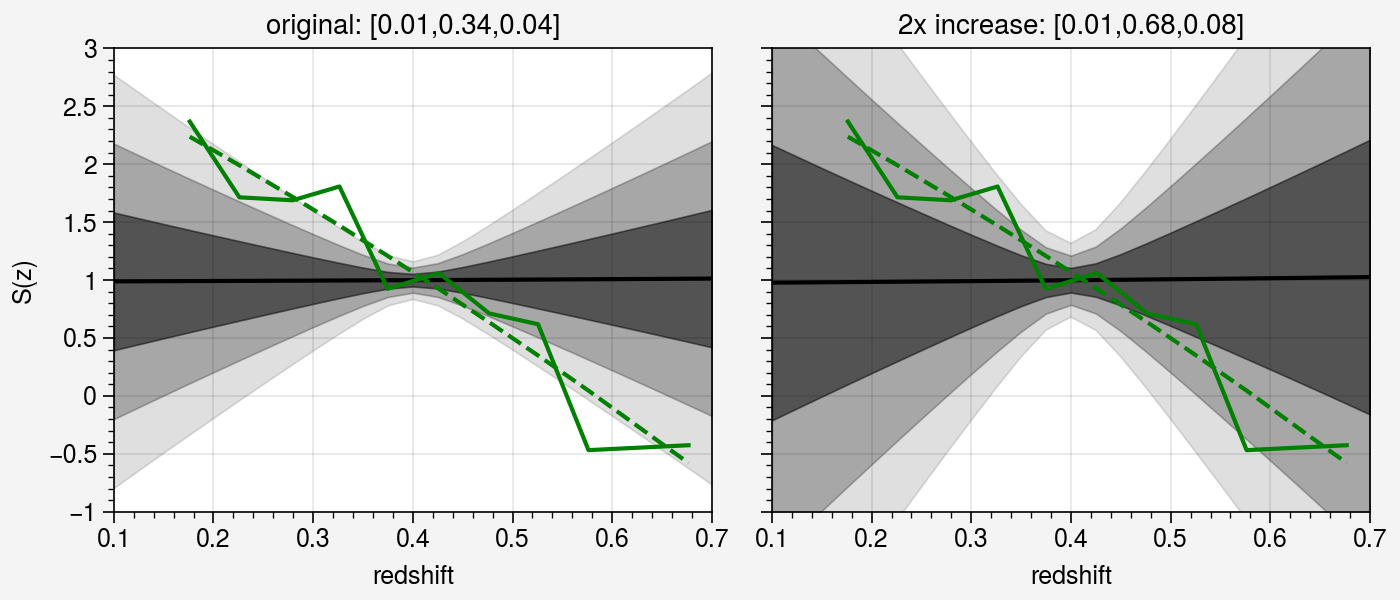

In [ ]:
pts_data = """\
0.1762081784386617, 2.575371549893843
0.22602230483271377, 1.921443736730361
0.27955390334572494, 1.8959660297239915
0.3263940520446097, 2.0148619957537157
0.3747211895910781, 1.1316348195329087
0.4260223048327138, 1.267515923566879
0.4765799256505576, 0.9193205944798302
0.5256505576208179, 0.8259023354564756
0.5762081784386617, -0.26114649681528634
0.6765799256505576, -0.21868365180467064"""

gx = []
gy = []
for line in pts_data.splitlines():
    _x, _y = line.split(",")
    gx.append(float(_x.strip()))
    gy.append(float(_y.strip()))
gx = np.array(gx)
gy = np.array(gy)

# set the value to 1 near zmid so
# that this function lies in the space of functions
# made by the mode
gy = gy - np.mean(gy) + 1.0


def lk(x, k):
    if k == 0:
        return np.ones_like(x)
    elif k == 1:
        return x
    elif k == 2:
        return 0.5 * (3.0 * x * x - 1)


def zbar(z, zmin, zmax):
    return 0.85 * (2 * z - zmax - zmin) / (zmax - zmin)


def sysu(u, z, zmin, zmax):
    nu = u.shape[0]
    zb = zbar(z, zmin, zmax)
    lkzb = np.vstack([lk(zb, k) for k in range(3)]).T
    coeff = (np.sqrt(2 * np.arange(nu) + 1) / 0.85).reshape((nu, 1)) * u
    tot = np.dot(lkzb, coeff)

    return tot

zmin = 0.1
zmax = 0.7
sigma_u = np.array([0.01, 0.34, 0.04])
sigma_u_new = sigma_u.copy()
fac = 2
sigma_u_new[2] *= fac
sigma_u_new[1] *= fac


def fun(u, gx, gy):
    gym = 1.0 + sysu(u.reshape(-1, 1), gx, zmin, zmax)
    gym = gym.flatten()
    return np.sum((gy - gym)**2)

res = scipy.optimize.minimize(
    fun,
    np.zeros(3),
    args=(gx, gy),
    options={"eps": 1e-12},
    method="L-BFGS-B",
)

print(
    "chi2 before and after variance adjustment (dof=3):",
    np.sum(res.x**2 / sigma_u**2),
    np.sum(res.x**2 / sigma_u_new**2),
)


z = np.linspace(zmin, zmax, 25)

n = 10000

fig, axs = uplt.subplots(nrows=1, ncols=2, figsize=(7, 3), sharey=4, sharex=0)

for i, su in enumerate([sigma_u, sigma_u_new]):
    ax = axs[0, i]
    rng = np.random.default_rng(seed=42)
    u = rng.normal(size=(3, n)) * su.reshape(-1, 1)
    yv = 1.0 + sysu(u, z, zmin, zmax)
    yv_std = np.std(yv, axis=-1)
    yv_mn = np.mean(yv, axis=-1)

    # for k in range(n):
    #     ax.plot(z, yv[:, k], color="k", alpha=min(1/n * 50, 1))

    ax.fill_between(z, yv_mn - 3 * yv_std, yv_mn + 3 * yv_std, color="k", alpha=0.125)
    ax.fill_between(z, yv_mn - 2 * yv_std, yv_mn + 2 * yv_std, color="k", alpha=0.25)
    ax.fill_between(z, yv_mn - yv_std, yv_mn + yv_std, color="k", alpha=0.5)
    ax.plot(z, yv_mn, color="k")

    ax.format(xlim=(0.1, 0.7), ylim=(-1, 3), xlabel="redshift", ylabel="S(z)")

    ax.plot(gx, gy, color="green")

    gym = 1.0 + sysu(res.x.reshape(-1, 1), gx, zmin, zmax)
    gym = gym.flatten()
    ax.plot(gx, gym, color="green", linestyle="dashed")

axs[0, 0].format(title="original: [" + ",".join([f"{v:0.4}" for v in sigma_u]) + "]")
axs[0, 1].format(title=f"{fac}x increase: [" + ",".join([f"{v:0.4}" for v in sigma_u_new]) + "]")

